In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # ignore tensorflow warning

import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from datetime import datetime
from IPython.display import clear_output
from typing import Tuple, List, Union, Optional

from models.SSDCAE import SSDCAE
from utils.image_handler import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BATCH_SIZE = 16
INPUT_SHAPE = (128, 128, 3)
EPOCHS = 100
SAVE_PERIOD = 10
LR = 1e-4
DROPOUT = .2
GAMMA = .7 #scheduler decay rate
DATA_PATH = 'datasets/subflickr/'
MODEL_SAVE_PATH = 'saved_models/weights/'
LOG_PATH = f'runs/SSDCAE_PReLU_{DROPOUT}DO_{LR}LR_{EPOCHS}EP_{BATCH_SIZE}BS_{int(datetime.timestamp(datetime.now()))}'

data_gen_args = dict(
    brightness_range=[0.5, 1.2],
    horizontal_flip=True,
    rescale=1/255,
    fill_mode='reflect',
    data_format='channels_last'
)
data_flow_args = dict(
    target_size=INPUT_SHAPE[:-1],
    batch_size=BATCH_SIZE,
    class_mode='input') # Since we want to reconstruct the input

In [4]:
train_datagen = ImageDataGenerator(**data_gen_args)
val_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator(**data_gen_args)

train_batches = train_datagen.flow_from_directory(
    os.path.join(os.path.abspath(DATA_PATH), 'train'),
    **data_flow_args)

val_batches = val_datagen.flow_from_directory(
    os.path.join(os.path.abspath(DATA_PATH), 'val'),
    **data_flow_args)

test_batches = val_datagen.flow_from_directory(
    os.path.join(os.path.abspath(DATA_PATH), 'test'),
    **data_flow_args)

train_noisy = generator(train_batches, noise_sd=.15)
val_noisy = generator(val_batches, noise_sd=.15)
test_noisy = generator(test_batches, noise_sd=.15)

Found 3520 images belonging to 1 classes.
Found 880 images belonging to 1 classes.
Found 1100 images belonging to 1 classes.


In [4]:
model = SSDCAE(
    filters=(32, 64, 64, 32),
    pre_filters=(32, 64, 64, 64),
    shape=INPUT_SHAPE,
    dropout=.2,
    use_prelu=True
)
model.build((None, *INPUT_SHAPE))
model.summary()
model.encode_decode_summary()

#scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#    LR,
#    decay_steps=len(train_batches),
#    decay_rate=GAMMA)
#model.compile(optimizer=Adam(scheduler), loss='mse', metrics=['accuracy'])

# for those who want to continue training from learned weights ONLY
# model = tf.keras.models.load_model('saved_models/76acc_4layers_2048vt_300ep_subpixel/weights.271-0.76.hdf5')
model.compile(optimizer=Adam(lr=LR), loss='mse', metrics=['accuracy'])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "ssdcae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 2048)              410624    
_________________________________________________________________
decoder (Sequential)         (None, 128, 128, 3)       1194339   
Total params: 1,604,963
Trainable params: 1,604,195
No

In [5]:
# for those who want to continue training from learned weights
model.load_weights('saved_models/76acc_4layers_2048vt_300ep_subpixel/weights.271-0.76.hdf5')

In [7]:
# Callbacks
saved_weight = os.path.join(MODEL_SAVE_PATH, 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5')
modelchk = tf.keras.callbacks.ModelCheckpoint(saved_weight, 
                                      monitor='val_accuracy', 
                                      verbose=1,
                                      save_best_only=True, 
                                      save_weights_only=False,
                                      mode='auto',
                                      save_freq='epoch') # save models every epoch
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH,
                                          histogram_freq=0,
                                          write_graph=True,
                                          write_images=True)

In [ ]:
hist = model.fit(train_noisy,
            steps_per_epoch = train_batches.samples // BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1, 
            validation_data=val_noisy,
            validation_steps = train_batches.samples // BATCH_SIZE,
            callbacks=[modelchk, tensorboard],
            use_multiprocessing=False).history

Epoch 1/100
220/220 [==============================] - 63s 191ms/step - loss: 0.0117 - accuracy: 0.6845 - val_loss: 0.0100 - val_accuracy: 0.7295

Epoch 00001: val_accuracy improved from -inf to 0.72955, saving model to saved_models/weights/weights.01-0.73.hdf5
Epoch 2/100
220/220 [==============================] - 41s 185ms/step - loss: 0.0115 - accuracy: 0.6811 - val_loss: 0.0098 - val_accuracy: 0.7343

Epoch 00002: val_accuracy improved from 0.72955 to 0.73428, saving model to saved_models/weights/weights.02-0.73.hdf5
Epoch 3/100
220/220 [==============================] - 41s 186ms/step - loss: 0.0118 - accuracy: 0.6830 - val_loss: 0.0100 - val_accuracy: 0.7319

Epoch 00003: val_accuracy did not improve from 0.73428
Epoch 4/100
220/220 [==============================] - 41s 185ms/step - loss: 0.0116 - accuracy: 0.6768 - val_loss: 0.0098 - val_accuracy: 0.7307

Epoch 00004: val_accuracy did not improve from 0.73428
Epoch 5/100
220/220 [==============================] - 41s 185ms/step

In [8]:
results = model.evaluate(test_noisy, batch_size=BATCH_SIZE)imgs/

   8959/Unknown - 833s 93ms/step - loss: 0.0099 - accuracy: 0.7577

KeyboardInterrupt: 

2022-05-15 22:06:39.984576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-15 22:06:40.919481: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-15 22:06:40.920117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-15 22:06:40.958618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 22:06:40.958726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-15 22:06:40.958745: I tensorflow/stream_executor/platform/def

2022-05-15 22:06:43.661084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-15 22:06:43.686436: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-05-15 22:06:43.795205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-15 22:06:44.570522: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-05-15 22:06:44.617371: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-15 22:06:45.243749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


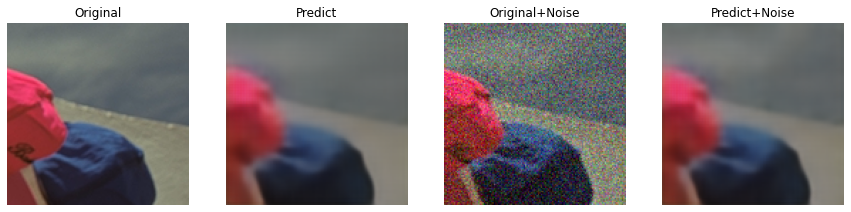

In [1]:
import cv2
from matplotlib import pyplot as plt
from utils.image_handler import padd_border

img = cv2.imread('imgs/kodim03.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = random_crop(img, (128, 128))
img_noise = (add_noise(img/255, sigma=.1)*255).astype('uint8')

latent = model.encode(np.expand_dims(img/255, axis=0))
recon = model.decode(latent)
recon = (recon.numpy()*255).reshape((128, 128, 3)).astype('uint8')
latent_noise = model.encode(np.expand_dims(img_noise/255, axis=0))
recon_noise = model.decode(latent_noise)
recon_noise = (recon_noise.numpy()*255).reshape((128, 128, 3)).astype('uint8')

fig, axs = plt.subplots(1, 4, figsize=(15, 15))

axs[0].imshow(img)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(recon)
axs[1].set_title('Predict')
axs[1].axis('off')

axs[2].imshow(img_noise)
axs[2].set_title('Original+Noise')
axs[2].axis('off')
axs[3].imshow(recon_noise)
axs[3].set_title('Predict+Noise')
axs[3].axis('off')
plt.show()